In [1]:
import pandas as pd
import json

In [2]:
def to_xlsx(name_json, name_xlsx):
    with open(name_json, 'r') as file:
        json_data = file.read()

    # Преобразование JSON-строки в словарь
    data = json.loads(json_data)

    # Извлечение списка бенчмарков
    benchmarks = data["benchmarks"]
    
    df = pd.DataFrame(benchmarks)
    
    selected_columns = df[['name', 'real_time', 'cpu_time', 'iterations']]
    selected_columns['real_time'] = selected_columns['real_time'].round(3)
    selected_columns['cpu_time'] = selected_columns['cpu_time'].round(3)
    
    selected_columns = selected_columns.rename(columns={'real_time': 'real_time(ms)',
                                     'cpu_time': 'cpu_time(ms)'})
    
    
    tmp = selected_columns.copy()
    split_data = selected_columns['name'].str.split('/', expand=True)
    tmp.drop(columns='name', inplace=True)
    tmp.insert(0, 'Algorithm', split_data[0])
    tmp.insert(1, 'Array', split_data[1])
    
    tmp['Array'] = tmp['Array'].str.split('.', n=1, expand=True)[0]
    
    tmp['Size'] = tmp['Array'].str.rsplit('_', n=1, expand=True)[1].astype(int)
    tmp['Array'] = tmp['Array'].str.rsplit('_', n=1, expand=True)[0]
    
    split_data = tmp['Algorithm'].str.rsplit('_', n=1, expand=True)
    tmp.drop(columns='Algorithm', inplace=True)
    #tmp.insert(0, 'Algorithm', split_data[0])
    tmp.insert(0, 'Algorithm', split_data[1])
    
    tmp['Algorithm'] = tmp['Algorithm'].str.replace('BM_', '')
    
    tmp.to_excel(name_xlsx, index=False)



In [3]:
to_xlsx('bm_normal_int.json', 'output_normal_int.xlsx')

C:\Users\odo20\AppData\Local\Temp\ipykernel_3148\1413422277.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_columns['real_time'] = selected_columns['real_time'].round(3)
C:\Users\odo20\AppData\Local\Temp\ipykernel_3148\1413422277.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_columns['cpu_time'] = selected_columns['cpu_time'].round(3)


In [4]:
table = pd.read_excel('output_normal_int.xlsx', sheet_name=0)
table

,Algorithm,Array,real_time(ms),cpu_time(ms),iterations,Size
0,MergeSort,int_uniform,1432.370,671.875,1,5000000
1,TimSort,int_uniform,788.942,304.688,2,5000000
2,CountingSort,int_uniform,61.619,25.670,28,5000000
3,MergeSort,int_uniform,2302.906,1109.375,1,8000000
4,TimSort,int_uniform,1268.439,578.125,1,8000000
...,...,...,...,...,...,...
244,MergeSort,int_uniform,0.086,0.047,16186,500
245,CountingSort,int_uniform,0.003,0.002,344615,500
246,InsertionSort,int_uniform,0.062,0.037,17920,500
247,BubbleSort,int_uniform,0.271,0.173,4978,500


In [5]:
import matplotlib.pyplot as plt

In [12]:
ls = ['-', '--', '-.', ':', (0, (3, 5, 1, 5, 1, 5)), 'dotted']

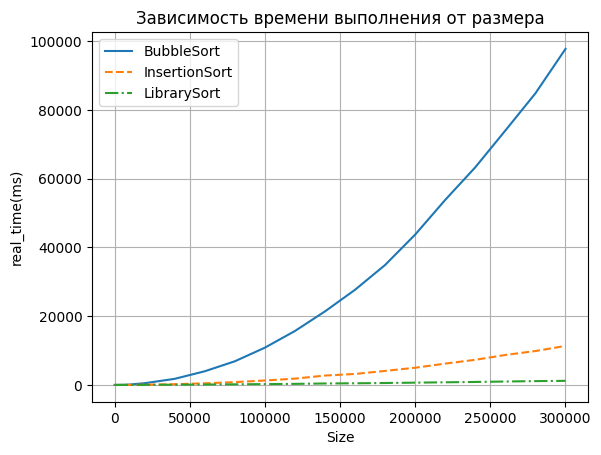

In [20]:
# Предполагаем, что 'table' - это ваш DataFrame
i = 0
for benchmark_name_tuple, group in table.groupby(['Algorithm', 'Array']):
    if benchmark_name_tuple[0] in ('BubbleSort', 'InsertionSort',  'LibrarySort'):
        #group = group[group['Size'] < 300_000]
        group = group.sort_values(by='Size', ascending=True)
        plt.plot(group["Size"], group["real_time(ms)"], linestyle=ls[i],  label=benchmark_name_tuple[0])
        i += 1

plt.xlabel("Size")
plt.ylabel("real_time(ms)")
plt.title("Зависимость времени выполнения от размера")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
from scipy.optimize import curve_fit
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

LibrarySort
Коэффициент a: 0.00029659576241068133
Коэффициент b: -23.396155051288133
R^2 коэффициент детерминации: 0.9856541039310684

MergeSort
Коэффициент a: 1.9500216677307705e-05
Коэффициент b: 0.3285024179187239
R^2 коэффициент детерминации: 0.9990920774002218

TimSort
Коэффициент a: 9.88747194676092e-06
Коэффициент b: 0.013541552947479829
R^2 коэффициент детерминации: 0.9997070133081097



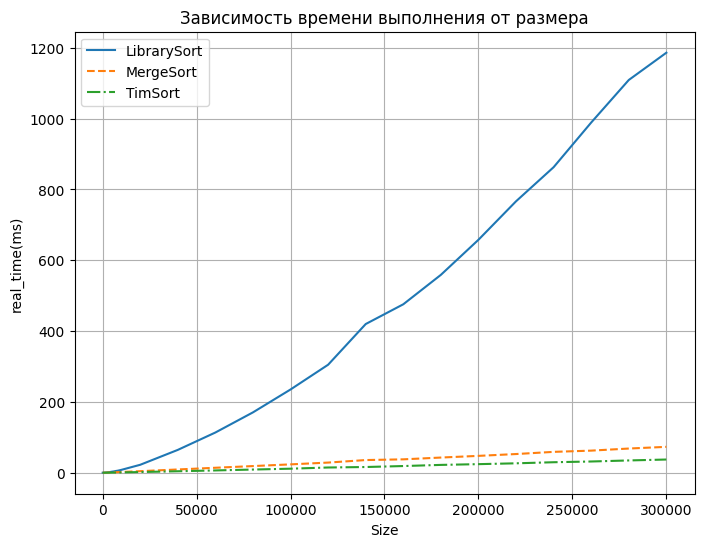

In [22]:
# Предполагаем, что 'table' - это ваш DataFrame
i = 0
plt.figure(figsize=(8, 6))
for benchmark_name_tuple, group in table.groupby(['Algorithm', 'Array']):
    if benchmark_name_tuple[0] not in ('BubbleSort', 'InsertionSort', 'CountingSort'):
        group = group[group['Size'] < 400000]
        #group = group[group['Size'] > 1000000]
        group = group.sort_values(by='Size', ascending=True)
        plt.plot(group["Size"], group["real_time(ms)"], linestyle=ls[i],  label=benchmark_name_tuple[0])
        i += 1
        
        
        n_log_n_values = group["Size"] * np.log(group["Size"])

        X = np.array(n_log_n_values).reshape(-1, 1)
        y = np.array(group["real_time(ms)"])

        # Выполним линейную регрессию
        regression_model = LinearRegression()
        regression_model.fit(X, y)
        
        # Получаем коэффициенты регрессии
        a = regression_model.coef_[0]
        b = regression_model.intercept_

        print(benchmark_name_tuple[0])
        print(f"Коэффициент a: {a}")
        print(f"Коэффициент b: {b}")
        
        # Предсказанные значения
        predicted_output_values = regression_model.predict(X)
        # Оценка модели
        r2 = r2_score(y, predicted_output_values)
        print(f"R^2 коэффициент детерминации: {r2}")
        print()
        

plt.xlabel("Size")
plt.ylabel("real_time(ms)")
plt.title("Зависимость времени выполнения от размера")
plt.legend()
plt.grid(True)
plt.show()

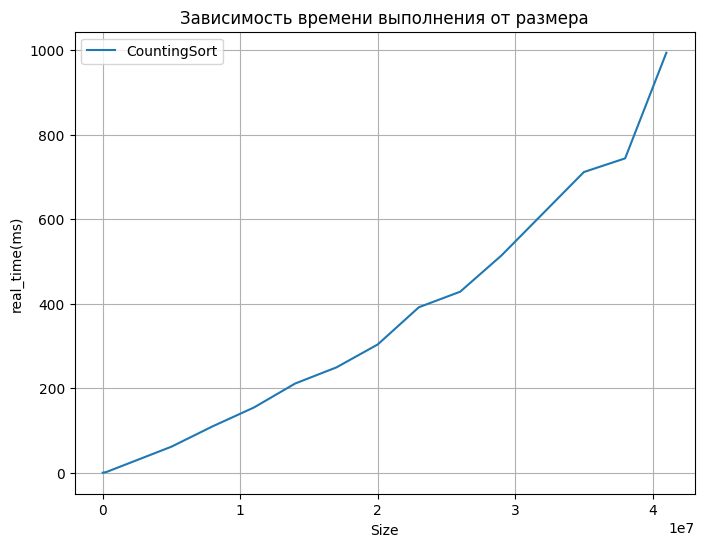

In [10]:
# Предполагаем, что 'table' - это ваш DataFrame
plt.figure(figsize=(8, 6))
for benchmark_name_tuple, group in table.groupby(['Algorithm', 'Array']):
    if benchmark_name_tuple[0] in ('CountingSort'):
        group = group[group['Size'] > 500]
        group = group.sort_values(by='Size', ascending=True)
        plt.plot(group["Size"], group["real_time(ms)"],  label=benchmark_name_tuple[0])

plt.xlabel("Size")
plt.ylabel("real_time(ms)")
plt.title("Зависимость времени выполнения от размера")
plt.legend()
plt.grid(True)
plt.show()

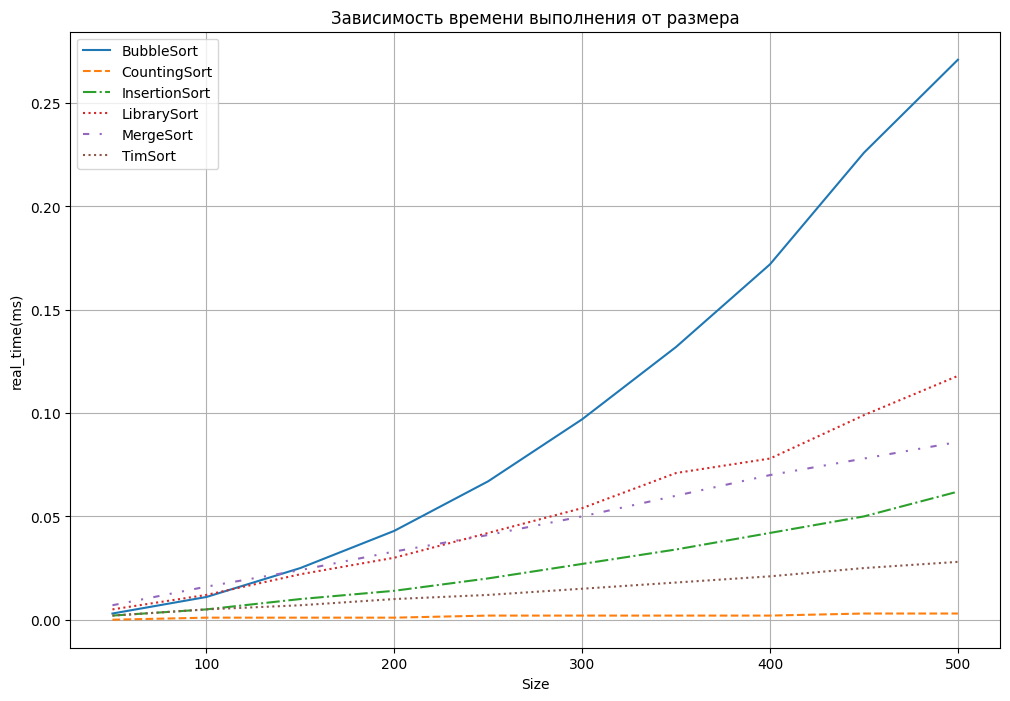

In [21]:
# Предполагаем, что 'table' - это ваш DataFrame
i = 0
plt.figure(figsize=(12, 8))
for benchmark_name_tuple, group in table.groupby(['Algorithm', 'Array']):
    
    group = group[group['Size'] < 1000]
    group = group.sort_values(by='Size', ascending=True)
    plt.plot(group["Size"], group["real_time(ms)"], ls=ls[i],  label=benchmark_name_tuple[0])
    i += 1

plt.xlabel("Size")
plt.ylabel("real_time(ms)")
plt.title("Зависимость времени выполнения от размера")
plt.legend()
plt.grid(True)
plt.show()